<a href="https://colab.research.google.com/github/Hubertmeteor/Projects/blob/main/Singapore_Resale_Flat_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting Singapore Resale Flat Prices

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import statsmodels.api as sm
from wordcloud import WordCloud
import plotly.express as px
import joblib
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import calendar
# import streamlit as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from math import sqrt

**Data Preprocessing and cleaning**


Reading and merging datasets

In [47]:
# Read the csv file into dataframe
df1 = pd.read_csv("/content/Resale19901999.csv")
df2 = pd.read_csv("/content/Resale2000Feb2012.csv")
df3 = pd.read_csv("/content/ResaleMar2012toDec2014.csv")
df4= pd.read_csv("/content/Resale2015toDec2016.csv")
df5 = pd.read_csv("/content/ResaleJan2017.csv")


Gaining insights into the available data by loading and reviewing all relevant datasets. There will be 5 datasets and we read each of them into separate dataframes such as df1, df2 etc.
When reading the datasets we notice that the column 'month' contains the month and year of sale. We also notice that only datasets 4 and 5 have the column 'remaining lease' and dataset 5 has it in string format.
Thus we remove the extra characters in the 'remaining lease' column of dataset 5.



In [48]:
# Extract the numeric part of 'remaining_lease', split by space, and convert to integer
df5['remaining_lease'] = df5['remaining_lease'].str.split(' ').str[0].astype('int64')

# Display the updated 'remaining_lease' column
print(df5['remaining_lease'])

0         61
1         60
2         62
3         62
4         62
          ..
174141    92
174142    62
174143    90
174144    62
174145    62
Name: remaining_lease, Length: 174146, dtype: int64


Now we merge all the datasets together.

In [49]:
# Merging datasets df1, df2, df3, df4 and df5
df_combined = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [50]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920349 entries, 0 to 920348
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                920349 non-null  object 
 1   town                 920349 non-null  object 
 2   flat_type            920349 non-null  object 
 3   block                920349 non-null  object 
 4   street_name          920349 non-null  object 
 5   storey_range         920349 non-null  object 
 6   floor_area_sqm       920349 non-null  float64
 7   flat_model           920349 non-null  object 
 8   lease_commence_date  920349 non-null  int64  
 9   resale_price         920349 non-null  float64
 10  remaining_lease      211299 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 77.2+ MB


In [51]:
df_combined.head(6)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN
5,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,NaN


**Feature Engineering**


Since the 'month' column contains both month and year, we split the column into 'month' and 'year'.

In [52]:
# Split 'month' into 'year' and 'month' columns
df_combined[['year', 'month']] = df_combined['month'].str.split('-', expand=True)

# Convert 'year' and 'month' columns to numeric types if needed
df_combined['year'] = pd.to_numeric(df_combined['year'])
df_combined['month'] = pd.to_numeric(df_combined['month'])

In [53]:
df_combined.head(6)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year
0,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,1990
1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN,1990
2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN,1990
3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN,1990
4,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN,1990
5,1,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,NaN,1990


The first 3 datasets did not have the column 'remaining lease' and thus when we merged all 5 datasets together we have Nan values on those rows. We use the below formula to obtain the values for those Nan values.

remaining lease = 99 - (Year - lease commence date)

In [54]:
# Calculate remaining lease for rows with NaN values
df_combined['remaining_lease'].fillna(99 - (df_combined['year'] - df_combined['lease_commence_date']), inplace=True)

In [55]:
df_combined.head(6)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year
0,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86.0,1990
1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86.0,1990
2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86.0,1990
3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86.0,1990
4,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85.0,1990
5,1,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,86.0,1990


In [57]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920349 entries, 0 to 920348
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                920349 non-null  int64  
 1   town                 920349 non-null  object 
 2   flat_type            920349 non-null  object 
 3   block                920349 non-null  object 
 4   street_name          920349 non-null  object 
 5   storey_range         920349 non-null  object 
 6   floor_area_sqm       920349 non-null  float64
 7   flat_model           920349 non-null  object 
 8   lease_commence_date  920349 non-null  int64  
 9   resale_price         920349 non-null  float64
 10  remaining_lease      920349 non-null  float64
 11  year                 920349 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 84.3+ MB


Now we check if there are any repetitions in the categorical values. And by doing so, we found out that there were indeed some in the columns 'flat_model' and 'flat_type', which can be simply resolved by mapping and changing the case of the characters.

In [58]:
# Changing the case to uppercase for consistency
df_combined['flat_model'] = df_combined['flat_model'].str.upper()

In [59]:
# Convert 'flat_type' values to lowercase
df_combined['flat_type'] = df_combined['flat_type'].str.lower()

# Standardize values to a common set of categories
type_mapping = {
    '1 room': '1 room',
    '3 room': '3 room',
    '4 room': '4 room',
    '5 room': '5 room',
    '2 room': '2 room',
    'executive': 'executive',
    'multi generation': 'multi generation',
    'multi-generation': 'multi generation'
}

df_combined['flat_type'] = df_combined['flat_type'].map(type_mapping)

# Changing the case to Uppercase
df_combined['flat_type'] = df_combined['flat_type'].str.upper()

In [61]:
df_combined.head(6)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year
0,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86.0,1990
1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86.0,1990
2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86.0,1990
3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86.0,1990
4,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85.0,1990
5,1,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,86.0,1990


We then check for outliers in the columns 'remaining lease' and 'storey range'. We found out that a few rows have a remaining lease more than 99 years which is not systematically possible and some values in storey range have a 5 incremental floor ranges, since these constitute very little to the dataset, we remove these outliers.

In [62]:
# Create a boolean mask to identify rows containing any of the specified values
mask = df_combined['remaining_lease']>99

# Use the boolean mask to drop rows
df_combined = df_combined[~mask]

In [63]:
# Drop rows where the 'storey_range' column contains specific values
values_to_drop = ['01 TO 05', '06 TO 10', '11 TO 15', '16 TO 20', '21 TO 25', '26 TO 30', '31 TO 35', '36 TO 40']

# Create a boolean mask to identify rows containing any of the specified values
mask = df_combined['storey_range'].isin(values_to_drop)

# Use the boolean mask to drop rows
df_combined = df_combined[~mask]

The storey range is split into upper bound and lower bound for a specific chart, which will be later discussed.

In [ ]:
# Split the 'storey_range' into lower and upper bounds
df_combined[['lower_bound', 'upper_bound']] = df_combined['storey_range'].str.split(' TO ', expand=True)

# Convert the lower and upper bounds to numeric values
df_combined['lower_bound'] = pd.to_numeric(df_combined['lower_bound'])
df_combined['upper_bound'] = pd.to_numeric(df_combined['upper_bound'])

Then we add 3 more columns 'price per square meter' - which is the result of dividing the 'resale price' and 'floor area', 'years holding' - which is the difference between the lease commence year and the year of sale and finally 'current remaining lease' which is the remaining lease of a house on current date.

In [ ]:
# Adding a new column 'price_per_sqm'
df_combined['price_per_sqm'] = df_combined['resale_price'] / df_combined['floor_area_sqm']

# Adding a new column 'years_holding'
df_combined['years_holding'] = df_combined['year'] - df_combined['lease_commence_date']

# Adding a new column 'current_remaining_lease'
df_combined['current_remaining_lease'] = df_combined['remaining_lease'] - (2024 - df_combined['year'])

In [ ]:
df_combined.head(6)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,lower_bound,upper_bound,price_per_sqm,years_holding,current_remaining_lease
0,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86.0,1990,10,12,290.322581,13,52.0
1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86.0,1990,4,6,193.548387,13,52.0
2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86.0,1990,10,12,258.064516,13,52.0
3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86.0,1990,7,9,193.548387,13,52.0
4,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85.0,1990,4,6,646.575342,14,51.0
5,1,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,86.0,1990,1,3,686.567164,13,52.0


Finally saved the dataset to a csv file.

In [ ]:
# Saving the clean dataset to a file
df_combined = df_combined.reset_index(drop=True)
df_combined.to_csv('Singapore_resale_flat_prices_updated.csv', index=False)


Exploratory Data Analysis (EDA)

We display the Basic statistics and visualizations.

In [ ]:
# Reading the dataset
df = pd.read_csv('Singapore_resale_flat_prices_updated.csv')

# Display basic information about the dataset
print(df.info())

# Display summary statistics of numerical columns
print(df.describe())

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913460 entries, 0 to 913459
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   month                    913460 non-null  int64  
 1   town                     913460 non-null  object 
 2   flat_type                913460 non-null  object 
 3   block                    913460 non-null  object 
 4   street_name              913460 non-null  object 
 5   storey_range             913460 non-null  object 
 6   floor_area_sqm           913460 non-null  float64
 7   flat_model               913460 non-null  object 
 8   lease_commence_date      913460 non-null  int64  
 9   resale_price             913460 non-null  float64
 10  remaining_lease          913460 non-null  float64
 11  year                     913460 non-null  int64  
 12  lower_bound              913460 non-null  int64  
 13  upper_bound              913460 non-null  int64  
 14  pric

Using Univariate and Bivariate analysis we obtain deeper insights.

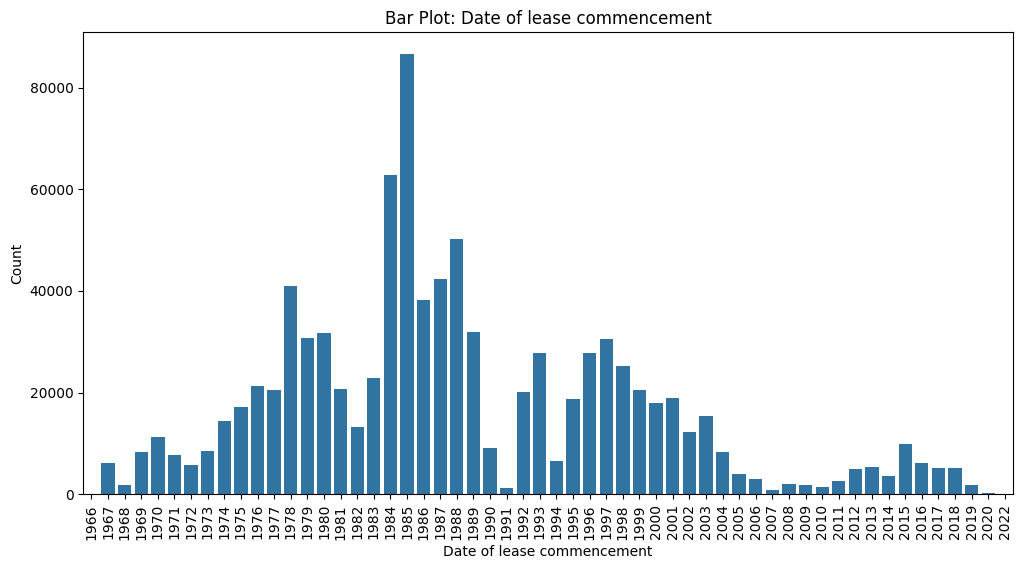

In [ ]:
# Bar Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='lease_commence_date', data=df)
plt.title('Bar Plot: Date of lease commencement')
plt.xlabel('Date of lease commencement')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

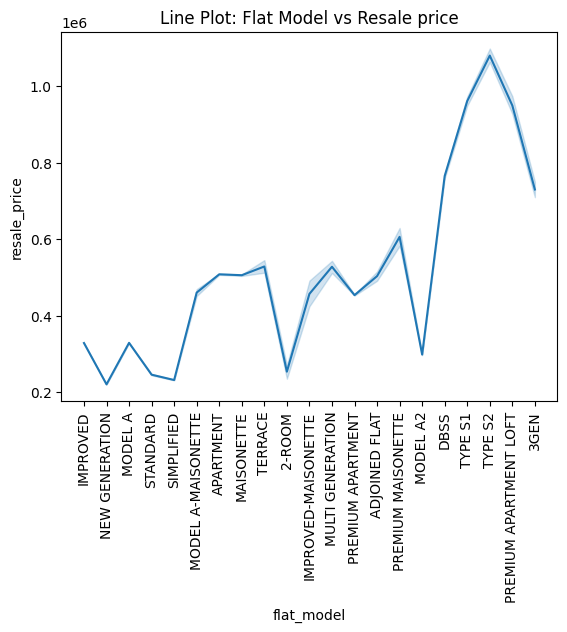

In [ ]:
# Line plot
sns.lineplot(x='flat_model', y='resale_price', data=df)
plt.title('Line Plot: Flat Model vs Resale price')
plt.xticks(rotation=90)
plt.show()

For example, in the above codes we explore the Bar plot and line plot of a few columns. In the below graph we find the highest floor sold for a particular year of lease commencement.

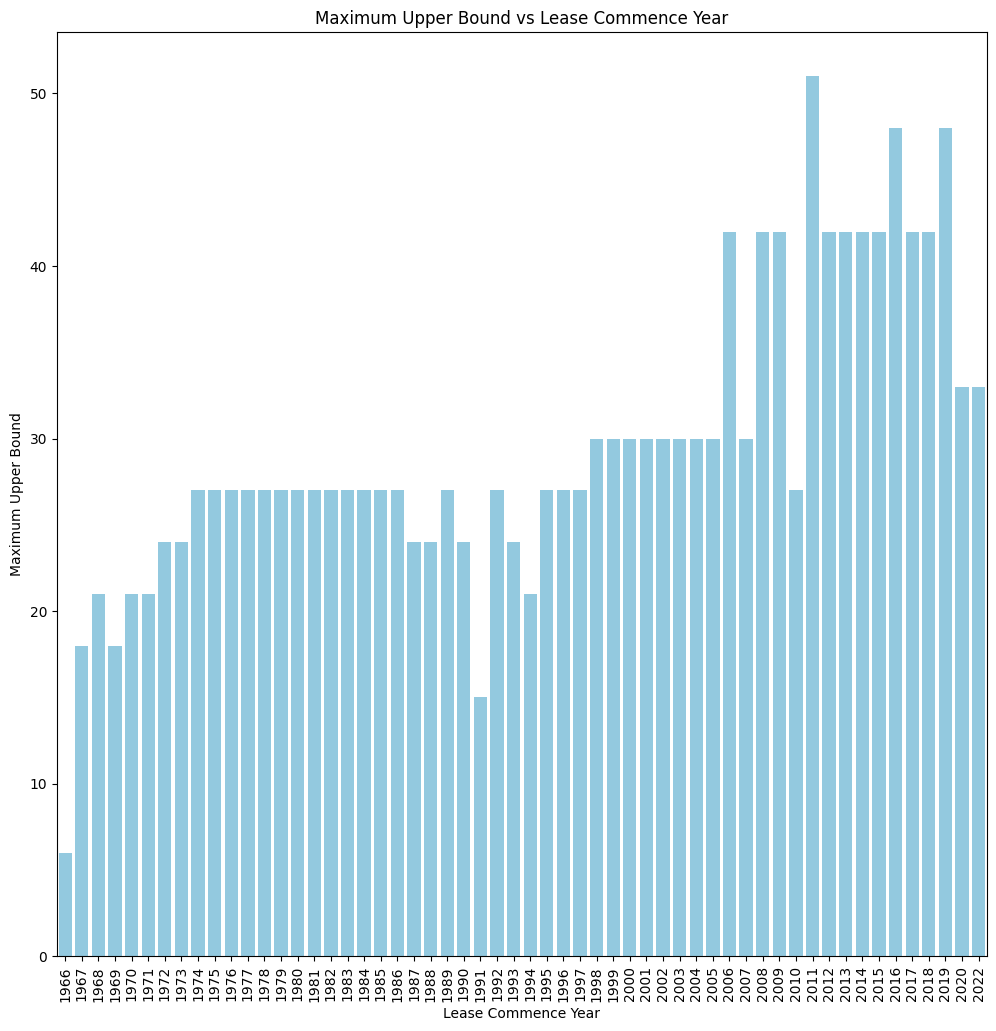

In [ ]:
plt.figure(figsize=(12, 12))

# Group by lease_commence_year and find the maximum value of upper_bound for each group
max_upper_bound = df.groupby('lease_commence_date')['upper_bound'].max().reset_index()

# Create a bar plot using seaborn
sns.barplot(x='lease_commence_date', y='upper_bound', data=max_upper_bound, color='skyblue')

# Set plot labels and title
plt.title('Maximum Upper Bound vs Lease Commence Year')
plt.xlabel('Lease Commence Year')
plt.ylabel('Maximum Upper Bound')
plt.xticks(rotation=90)

# Show the plot
plt.show()

**Model Building and Evaluation**



Constructing and assessing machine learning models, including Linear Regression, Decision Trees, and K-Nearest Neighbours.
Taking the necessary columns and dropping irrelevant ones and splitting them into training and testing.

In [64]:
# Drop irrelevant columns
selected_columns = ['year', 'town', 'flat_type', 'flat_model', 'storey_range',
                    'floor_area_sqm', 'lease_commence_date', 'remaining_lease',
                    'current_remaining_lease', 'years_holding', 'resale_price']
dftrain = df[selected_columns]

# Separate features (X) and target variable (y)
X = dftrain.drop('resale_price', axis=1)
y = dftrain['resale_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Assume df is your DataFrame with the selected columns
# Drop irrelevant columns
# selected_columns = ['year', 'town', 'flat_type', 'flat_model', 'storey_range',
#                     'floor_area_sqm', 'lease_commence_date', 'remaining_lease',
#                     'current_remaining_lease', 'years_holding', 'resale_price']
# dftrain = df[selected_columns]

# Separate features (X) and target variable (y)
X = dftrain.drop('resale_price', axis=1)
y = dftrain['resale_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps for numeric and categorical features
numeric_features = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'current_remaining_lease', 'years_holding']
categorical_features = ['year', 'town', 'flat_type', 'flat_model', 'storey_range']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the linear regression model
model = LinearRegression()

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')


Mean Squared Error: 2443118632.413194
R-squared Score: 0.9139177386895225


**Decision trees**

In [66]:
# Create the regression model
model = DecisionTreeRegressor(random_state=42)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'lease_commence_date',
                                                   'remaining_lease',
                                                   'current_remaining_lease',
                                                   'years_holding']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'town', 'flat_type',
                                                   'flat_model',
                                                   'storey_range'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [67]:

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')


Mean Squared Error: 974148374.369351
R-squared Score: 0.965676290211577


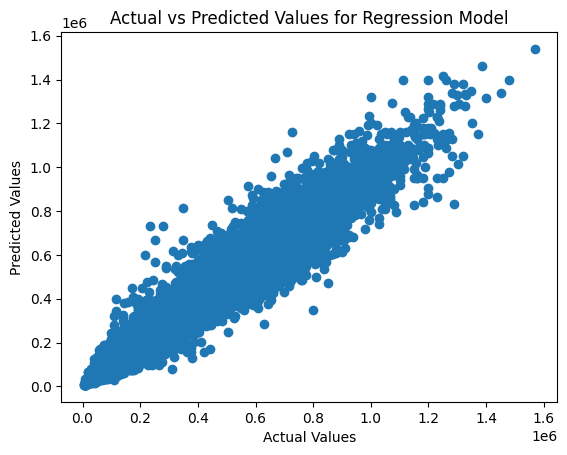

In [68]:
import matplotlib.pyplot as plt

# Predict the target values on the test set
y_pred = pipeline.predict(X_test)

# Create a scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Regression Model")
plt.show()


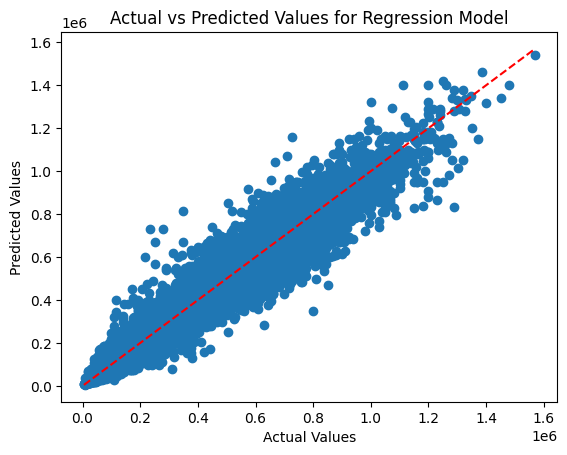

In [69]:
import numpy as np

# Plot the diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')

# Scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Regression Model")
plt.show()


In [70]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2}")


Mean Absolute Error: 20695.853343096253
Mean Squared Error: 974148374.369351
Root Mean Squared Error: 31211.35008885952
R-squared Score: 0.965676290211577


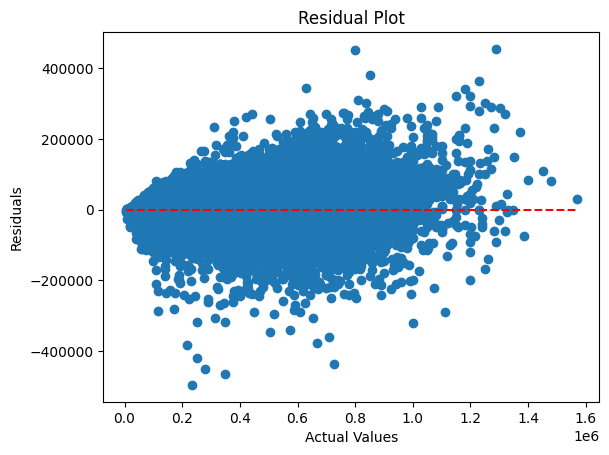

In [71]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.hlines(0, min(y_test), max(y_test), colors='red', linestyles='dashed')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


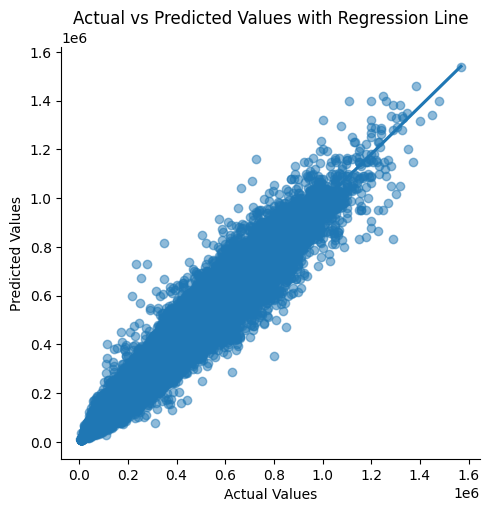

In [72]:
import seaborn as sns

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Scatter plot with regression line
sns.lmplot(x='Actual', y='Predicted', data=results_df, scatter_kws={'alpha':0.5})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Regression Line')
plt.show()


In [79]:
# Create a DataFrame with new input values for prediction
new_data = pd.DataFrame({
    'floor_area_sqm': [113],
    'lease_commence_date': [1996],
    'remaining_lease': [90],
    'current_remaining_lease': [71],
    'years_holding': [25],
    'year': [2013],
    'town': ['ANG MO KIO'],   # Enclosed in quotes to indicate a string
    'flat_type': ['1 ROOM'],  # Enclosed in quotes to indicate a string
    'flat_model': ['IMPROVED'],  # Enclosed in quotes to indicate a string
    'storey_range': ['07 TO 09'],  # Enclosed in quotes to indicate a string
})

# Make predictions
new_predictions = pipeline.predict(new_data)

# Display the predictions
print(new_predictions)


[725000.]


**K-Nearest Neighbours**

In [ ]:
# Create the regression model
model = KNeighborsRegressor()

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'lease_commence_date',
                                                   'remaining_lease',
                                                   'current_remaining_lease',
                                                   'years_holding']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'town', 'flat_type',
                                                   'flat_model',
                                                   'storey_range'])])),
                ('model', KNeighborsRegressor())])